In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime

start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('2025-01-01') # used to force chart to plot to end of 5 year period

# Interest Rates
RBA monthly lending rates from 1959

In [79]:
# FILEPATH: /workspaces/investment-analytics/notebooks/finance/Interest-Rates.ipynb
# RBA monthly lending rates from 1959
csv_file = 'https://www.rba.gov.au/statistics/tables/csv/f5-data.csv'
local_file = '../data/f5-data.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or datetime.datetime.now() - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)

In [80]:
# First 10 rows are descriptive header rows and data is not UTF-8 encoded, use Windows code page 1252 instead
# FILRHLBVS = Financial Interest; Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier
dfInterest = pd.read_csv(local_file, skiprows=10, encoding='cp1252', usecols=['Series ID', 'FILRHLBVS'])
dfInterest.dropna(subset=['Series ID'], inplace=True)
dfInterest.tail()

,Series ID,FILRHLBVS
774,Jul-2023,8.52
775,Aug-2023,8.52
776,Sep-2023,8.52
777,Oct-2023,8.52
778,Nov-2023,8.77


In [81]:
dfInterest.rename(columns={'Series ID': 'Date'}, inplace=True)
# source data is in the format 'Jan-1959' %b-%Y
dfInterest['Date'] = pd.to_datetime(dfInterest['Date'], format='%b-%Y')
dfInterest.set_index('Date', inplace=True)
# 12 months per year * 3 years = 36 months
dfInterest['3_yr_rolling'] = dfInterest['FILRHLBVS'].rolling(window=36, min_periods=1).mean()
dfInterest.tail()

,FILRHLBVS,3_yr_rolling
Date,,
2023-07-01,8.52,5.617222
2023-08-01,8.52,5.728333
2023-09-01,8.52,5.839444
2023-10-01,8.52,5.950556
2023-11-01,8.77,6.068611


# Inflation Rates
RBA Quarterly inflation rates from 1922

In [82]:
# RBA quarterly inflation rates from 1922
csv_file = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age = datetime.timedelta(days=1)
if not os.path.exists(local_file) or datetime.datetime.now() - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)

In [83]:
# First 10 rows are descriptive header rows and data is not UTF-8 encoded, use Windows code page 1252 instead
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year
dfInflation = pd.read_csv(local_file, skiprows=10, encoding='cp1252', usecols=['Series ID', 'GCPIAGYP'])
dfInflation.dropna(subset=['Series ID'], inplace=True)
dfInflation.tail()

,Series ID,GCPIAGYP
404,Jun-2023,6.0
405,Sep-2023,5.4
406,Dec-2023,NaN
407,Mar-2024,NaN
408,Jun-2024,NaN


In [84]:
dfInflation.rename(columns={'Series ID': 'Date'}, inplace=True)
# source data is in the format 'Jan-1959' %b-%Y
dfInflation['Date'] = pd.to_datetime(dfInflation['Date'], format='%b-%Y')
dfInflation.set_index('Date', inplace=True)
# 4 quarters per year * 3 years = 12 quarters
dfInflation['3_yr_rolling'] = dfInflation['GCPIAGYP'].rolling(window=12, min_periods=1).mean()
dfInflation.tail()

,GCPIAGYP,3_yr_rolling
Date,,
2023-06-01,6.0,4.358333
2023-09-01,5.4,4.750000
2023-12-01,NaN,5.100000
2024-03-01,NaN,5.500000
2024-06-01,NaN,5.688889


# Combine Data

In [85]:
dfInterest = dfInterest.loc[dfInterest.index >= start_date]
dfInflation = dfInflation.loc[dfInflation.index >= start_date]

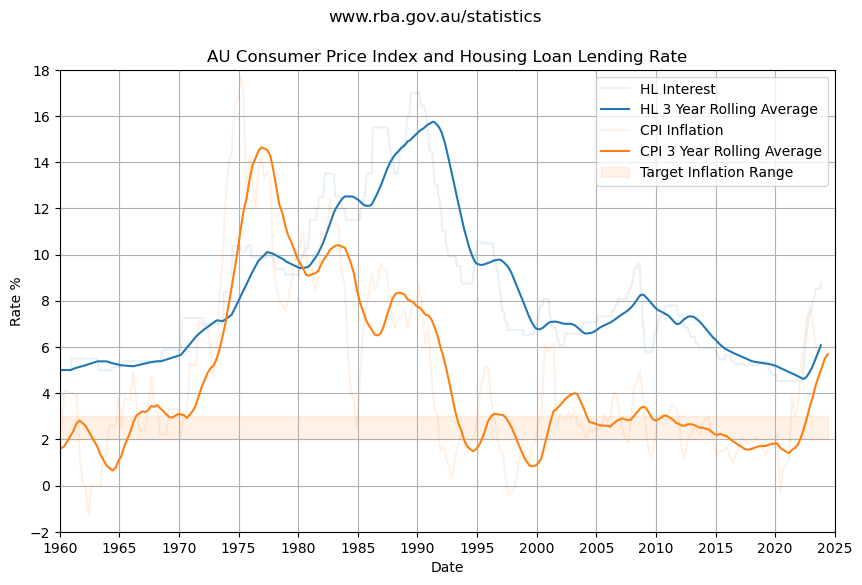

In [86]:
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 6))
plt.plot(dfInterest.index, dfInterest['FILRHLBVS'], label='HL Interest', color='#1f77b4', alpha=0.1)
plt.plot(dfInterest.index, dfInterest['3_yr_rolling'], label='HL 3 Year Rolling Average',color='#1f77b4')
plt.plot(dfInflation.index, dfInflation['GCPIAGYP'], label='CPI Inflation', color='#ff7f0e', alpha=0.1)
plt.plot(dfInflation.index, dfInflation['3_yr_rolling'], label='CPI 3 Year Rolling Average', color='#ff7f0e')
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index and Housing Loan Lending Rate')
plt.grid(True)
plt.xlim(left=start_date, right=end_date)
plt.ylim(bottom=-2, top=18) 
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set major ticks every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

# Add a horizontal band between y=2 and y=3
plt.fill_between(dfInflation.index, 2, 3, color='#ff7f0e', alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color='#ff7f0e', alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
plt.legend(handles=handles, loc='best')
plt.show()